In [0]:
import argparse
import torch
import torch.nn.functional as F
import torch.optim as optim
import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import datasets, transforms

from torchsummary import summary


In [0]:
from google.colab import drive
drive.mount('/content/drive')

current_path = '/content/drive/My Drive/My coding/Hillel Scool/Занятие 10 - Домашка 8/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import json
import sys, os
import pandas as pd
import numpy as np

def writeToJSONFile(path, fileName, data):
    print(path)
    print(fileName)
    filePathNameWExt = path + fileName + '.json'
    print(filePathNameWExt)
    with open(filePathNameWExt, 'w') as fp:
        json.dump(data, fp)
    return path + fileName

def readFromJSONFile(path, fileName):
    filePathNameWExt = path + '/' + fileName + '.json'
    with open(filePathNameWExt, 'r') as fp:
        data = json.load(fp)
    return data

def save_my_param(model, dict_for_save, after_n_epochs=0, previous_file=None):
    # путь к файлу нужно указывать самостоятельно без расширения
    # after_n_epochs    - накапливаем количество эпох и в новый файл дописываем

    if previous_file :
        file_dir = os.path.dirname(previous_file)
        file_name_full = os.path.basename(previous_file)
        file_name = os.path.splitext(file_name_full)[0] + '_' + str(after_n_epochs)
    else:
#         это два глобальныйх (входящих) значения (пока пусть так работает)
        file_dir = current_path
        file_name = str(model.name2) + '_param_'+str(after_n_epochs).rjust(2,'0')
    d = dict(dict_for_save=dict_for_save,after_n_epochs=after_n_epochs)
    d_pd = pd.DataFrame([d])
    return writeToJSONFile(file_dir,file_name,d_pd.to_json(orient='split'))


In [0]:
class DResNetCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.name2 = 'DResNetCNN'
        
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=0, stride=1)
        self.ac1   = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=1)
#         maxpool
        self.ac2   = torch.nn.ReLU()
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
#         maxpool        
        self.ac3   = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.ac4   = torch.nn.ReLU()  
        self.conv5 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.ac5   = torch.nn.ReLU() 
        self.conv6 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.ac6   = torch.nn.ReLU() 
        self.conv7 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.ac7   = torch.nn.ReLU() 
        self.conv8 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.ac8   = torch.nn.ReLU() 
        self.conv9 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.ac9   = torch.nn.ReLU() 
        self.conv10= torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.ac10  = torch.nn.ReLU() 
  
#         flatten
        self.fc11 = torch.nn.Linear(3136, 256)
        self.ac11 = torch.nn.ReLU()
        self.fc12 = torch.nn.Linear(256,  128)
        self.ac12 = torch.nn.ReLU()
        self.fc13 = torch.nn.Linear( 128,   10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.ac1(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.ac2(x)
        x = self.conv3(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.ac3(x)
        
        last_output = x
        x = self.conv4(x)
        x = self.ac4(x) + last_output
        last_output = x
        x = self.conv5(x)
        x = self.ac5(x) + last_output
        last_output = x
        x = self.conv6(x)
        x = self.ac6(x) + last_output
        last_output = x
        x = self.conv7(x)
        x = self.ac7(x) + last_output
        last_output = x
        x = self.conv8(x)
        x = self.ac8(x) + last_output
        last_output = x
        x = self.conv9(x)
        x = self.ac9(x) + last_output
        last_output = x
        x = self.conv10(x)
        x = self.ac10(x) + last_output
        
        
        x = x.view(-1, 64*7*7)
        x = self.fc11(x)
        x = self.ac11(x)
        x = self.fc12(x)
        x = self.ac12(x)
        x = self.fc13(x)
        return F.log_softmax(x, dim=1)

In [0]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
      
#         data = data.reshape(len(data), 3072)
      
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} correct: {:.2f}% '.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), 100. * correct/len(train_loader.dataset)))
    return loss.item(), correct / len(train_loader.dataset)
  
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          
#             data = data.reshape(len(data),3072)
          
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)
      
def read_settings():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch Examples')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=15, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=80, metavar='N',
                        help='how many batches to wait before logging training status')

    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')
    
    args = parser.parse_args([])
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    print('use_cuda : {}'.format(use_cuda))
    
    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    return args, kwargs, device

def load_dataset(args,kwargs):
    # CIFAR10.
    train_dataset = datasets.CIFAR10('data', 
                                      train=True, 
                                      download=True, 
                                      transform=transforms.ToTensor())

    test_dataset = datasets.CIFAR10('data', 
                                     train=False, 
                                     transform=transforms.ToTensor())
    print(len(train_dataset),len(test_dataset),type(test_dataset))
    
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=args.batch_size, 
                                               shuffle=True, 
                                               **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=args.test_batch_size,
                                              shuffle=True, 
                                              **kwargs)
    print(train_loader.dataset.data.shape)
    print(test_loader.dataset.data.shape)
    
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    for data, target in train_loader:
        break
    print(data.shape)
    print(data[0].shape)
    plt.figure(figsize=(12,5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        plt.title(classes[target[i]])
        plt.imshow(data[i].permute(1, 2, 0))
    plt.show()
    return train_loader, test_loader

def show_2_in_line(loss_train, accuracy_train, loss_test, accuracy_test, epochs=1, model_name=''):
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.title(model_name + ' - Loss')
    plt.xlabel('epochs')
    plt.plot(range(epochs),loss_train, 'g',label='train')
    plt.plot(range(epochs),loss_test, 'r',label='test')
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.title(model_name + ' - Accuracy')
    plt.xlabel('epochs')
    plt.plot(range(epochs),accuracy_train,'g',label='train')
    plt.plot(range(epochs),accuracy_test,'r',label='test')
    plt.legend()
    plt.grid()
    plt.show()
  
def main():

    args, kwargs, device = read_settings()
    train_loader, test_loader = load_dataset(args, kwargs)
    
# start - загрузка модели + параметры накопления

    model = DResNetCNN().to(device)
    print(str(model.name2))
    summary(model, input_size=(3,32,32))
  
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)


    train_last_loss_list = []
    train_accuracy_list = []
    test_average_loss_list = []
    test_accuracy_list = []
    
    start_epoch = 1
    
    dict_for_save = dict()
# end - загрузка модели + параметры накопления
    start = datetime.datetime.now()
    for epoch in range(start_epoch, args.epochs + 1):
        train_last_loss, train_accuracy = train(args, model, device, train_loader, optimizer, epoch)
        test_average_loss, test_accuracy = test(args, model, device, test_loader)
        train_last_loss_list.append(train_last_loss)
        train_accuracy_list.append(train_accuracy)
        test_average_loss_list.append(test_average_loss)
        test_accuracy_list.append(test_accuracy)

#         start - что сохраняем каждую эпоху по одной модели
        if (args.save_model):
            f = current_path + str(model.name2) + '_model_' + str(epoch).rjust(2,'0') + ".pt"
            torch.save(model,f)
            print('Save model in {}'.format(f))
        dict_for_save = dict(train_last_loss_list = train_last_loss_list,
                             train_train_accuracy_listaccuracy = train_accuracy_list,
                             test_average_loss_list = test_average_loss_list,
                             test_accuracy_list = test_accuracy_list
#                             ,может время или что еще захочу
                            )
        print(save_my_param(model, dict_for_save, after_n_epochs=epoch))
#         end - что сохраняем каждую эпоху по одной модели

    end = datetime.datetime.now()
    time_train = end-start        
    print('Model ( {} ) time - {}'.format(str(model.name2), time_train))
    
    show_2_in_line(train_last_loss_list, train_accuracy_list, test_average_loss_list, test_accuracy_list, args.epochs, str(model.name2))


use_cuda : False
Files already downloaded and verified
50000 10000 <class 'torchvision.datasets.cifar.CIFAR10'>
(50000, 32, 32, 3)
(10000, 32, 32, 3)
torch.Size([64, 3, 32, 32])
torch.Size([3, 32, 32])


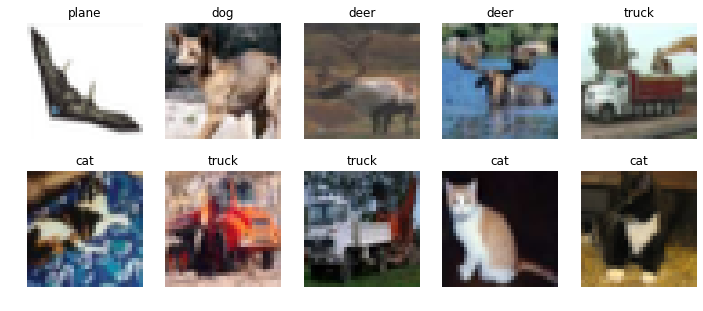

DResNetCNN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
              ReLU-2           [-1, 16, 30, 30]               0
            Conv2d-3           [-1, 32, 28, 28]           4,640
              ReLU-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
              ReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          36,928
              ReLU-8             [-1, 64, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          36,928
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          36,928
             ReLU-12             [-1, 64, 7, 7]               0
           Conv2d-13             [-1, 64, 7, 7]          36,928
             ReLU-14        

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DResNetCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train Epoch: 2 [0/50000 (0%)]	Loss: 1.940874 correct: 0.04% 
Train Epoch: 2 [5120/50000 (10%)]	Loss: 2.054460 correct: 2.92% 
Train Epoch: 2 [10240/50000 (20%)]	Loss: 1.974035 correct: 5.91% 
Train Epoch: 2 [15360/50000 (31%)]	Loss: 1.899664 correct: 9.09% 
Train Epoch: 2 [20480/50000 (41%)]	Loss: 2.124499 correct: 12.49% 
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.778311 correct: 15.61% 
Train Epoch: 2 [30720/50000 (61%)]	Loss: 1.684114 correct: 19.33% 
Train Epoch: 2 [35840/50000 (72%)]	Loss: 1.699316 correct: 23.03% 
Train Epoch: 2 [40960/50000 (82%)]	Loss: 1.738117 correct: 26.76% 
Train Epoch: 2 [46080/50000 (92%)]	Loss: 1.795774 correct: 30.63% 

Test set: Average loss: 1.7125, Accuracy: 3721/10000 (37.21%)

Save model in /content/drive/My Drive/My coding/Hillel Scool/Занятие 10 - Домашка 8/DResNetCNN_model_02.pt
/content/drive/My Drive/My coding/Hillel Scool/Занятие 10 - Домашка 8/
DResNetCNN_param_02
/content/drive/My Drive/My coding/Hillel Scool/Занятие 10 - Домашка 8/DResNetC

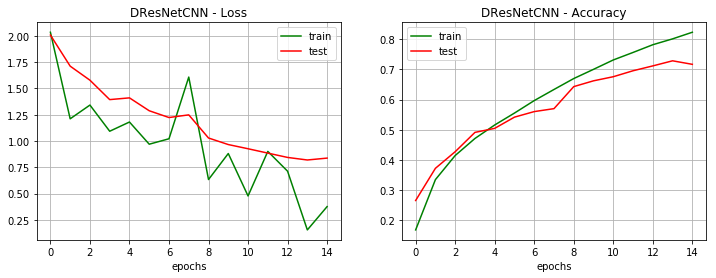

In [0]:
main()